https://github.com/SAISQUARE/raveendratal

In [17]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##  1. How to create partitions based on year and month
2022/01
2022/02
2022/03

on premises, traditional databases.
Date format: dd-mm-yyyy

spark date format: yyyy-MM-dd

**Data partitioning:**

Is critical to data processing performance especially for large volume of data, Spark data partition is a way to split the data into multiple partitions so that you can execute transformations on multiple partitions in parallel which allows completing the job faster. Partitions are basic units of parallelism in Spark and RDDs, DataFrames and Datasets are collections of partitions. You can use methods like `repartition`, `coalesce`, `partitionBy` and `repartitionByRange` to control the partitioning of your data. Partitioning can also improve the performance of your queries by reducing data shuffling and enabling partition pruning.

PySpark partition is a way to split a large dataset into smaller datasets based on one or more partition keys. When you create a DataFrame from a file/table, based on certain parameters PySpark creates the DataFrame with a certain number of partitions in memory. This is one of the main advantages of PySpark DataFrame over Pandas DataFrame. Transformations on partitioned data run faster as they execute transformations parallelly for each partition.

In [ ]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
sc = SparkSession.builder.getOrCreate()

In [ ]:
sdf_emp = sc.read.csv("emp.csv", header = True, inferSchema = True)
sdf_emp.printSchema()

root
 |-- EMPNO: string (nullable = true)
 |-- ENAME: string (nullable = true)
 |-- JOB: string (nullable = true)
 |-- MGR: string (nullable = true)
 |-- HIREDATE: string (nullable = true)
 |-- SAL: string (nullable = true)
 |-- COMM: string (nullable = true)
 |-- DEPTNO: string (nullable = true)
 |-- UPDATED_DATE: string (nullable = true)



In [ ]:
sdf_emp.show(5)

+-----+------+--------+----+----------+----+----+------+------------+
|EMPNO| ENAME|     JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE|
+-----+------+--------+----+----------+----+----+------+------------+
| 7369| SMITH|   CLERK|7902|17-12-1980| 800|null|    20|  2022-01-01|
| 7499| ALLEN|SALESMAN|7698|20-02-1981|1600| 300|    30|  2022-01-01|
| 7521|  WARD|SALESMAN|7698|22-02-1981|1250| 500|    30|  2022-01-01|
| 7566| JONES| MANAGER|7839|04-02-1981|2975|null|    20|  2022-01-05|
| 7654|MARTIN|SALESMAN|7698|21-09-1981|1250|1400|    30|  2022-01-03|
+-----+------+--------+----+----------+----+----+------+------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import to_date
#change string to Date datetype
sdf_emp = sdf_emp.withColumn("HIREDATE", to_date("HIREDATE", "dd-MM-yyyy")).fillna({"HIREDATE":"9999-12-31"})
sdf_emp.show(5)
sdf_emp.printSchema()

+-----+------+--------+----+----------+----+----+------+------------+
|EMPNO| ENAME|     JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE|
+-----+------+--------+----+----------+----+----+------+------------+
| 7369| SMITH|   CLERK|7902|1980-12-17| 800|null|    20|  2022-01-01|
| 7499| ALLEN|SALESMAN|7698|1981-02-20|1600| 300|    30|  2022-01-01|
| 7521|  WARD|SALESMAN|7698|1981-02-22|1250| 500|    30|  2022-01-01|
| 7566| JONES| MANAGER|7839|1981-02-04|2975|null|    20|  2022-01-05|
| 7654|MARTIN|SALESMAN|7698|1981-09-21|1250|1400|    30|  2022-01-03|
+-----+------+--------+----+----------+----+----+------+------------+
only showing top 5 rows

root
 |-- EMPNO: string (nullable = true)
 |-- ENAME: string (nullable = true)
 |-- JOB: string (nullable = true)
 |-- MGR: string (nullable = true)
 |-- HIREDATE: date (nullable = true)
 |-- SAL: string (nullable = true)
 |-- COMM: string (nullable = true)
 |-- DEPTNO: string (nullable = true)
 |-- UPDATED_DATE: string (nullable = true)



In [ ]:
#creating two year and month new columns base on hiredate date field
from pyspark.sql.functions import date_format
sdf_emp = (sdf_emp.withColumn("YEAR", date_format("HIREDATE", "yyyy"))
                  .withColumn("MONTH", date_format("HIREDATE", "MM")))
sdf_emp.show(5)
sdf_emp.printSchema()

+-----+------+--------+----+----------+----+----+------+------------+----+-----+
|EMPNO| ENAME|     JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE|YEAR|MONTH|
+-----+------+--------+----+----------+----+----+------+------------+----+-----+
| 7369| SMITH|   CLERK|7902|1980-12-17| 800|null|    20|  2022-01-01|1980|   12|
| 7499| ALLEN|SALESMAN|7698|1981-02-20|1600| 300|    30|  2022-01-01|1981|   02|
| 7521|  WARD|SALESMAN|7698|1981-02-22|1250| 500|    30|  2022-01-01|1981|   02|
| 7566| JONES| MANAGER|7839|1981-02-04|2975|null|    20|  2022-01-05|1981|   02|
| 7654|MARTIN|SALESMAN|7698|1981-09-21|1250|1400|    30|  2022-01-03|1981|   09|
+-----+------+--------+----+----------+----+----+------+------------+----+-----+
only showing top 5 rows

root
 |-- EMPNO: string (nullable = true)
 |-- ENAME: string (nullable = true)
 |-- JOB: string (nullable = true)
 |-- MGR: string (nullable = true)
 |-- HIREDATE: date (nullable = true)
 |-- SAL: string (nullable = true)
 |-- COMM: string (nulla

In [ ]:
#Using PartitionBy with Two Columns creating partitions

#partitionBy() multiple columns
sdf_emp.write.option("header",True) \
             .partitionBy("YEAR","MONTH") \
             .mode("overwrite") \
             .csv("year-month-partitions")


## 2. How to handle or how to read variable/dynamic number of column data file

This dataset have multiple missing values:

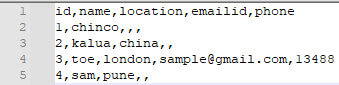



File with columns

File without columns

In [ ]:
sdf2 = sc.read.csv("exercise-2.csv", inferSchema = True)
sdf2.show()

+---+------+--------+----------------+-----+
|_c0|   _c1|     _c2|             _c3|  _c4|
+---+------+--------+----------------+-----+
| id|  name|location|         emailid|phone|
|  1|chinco|    null|            null| null|
|  2| kalua|   china|            null| null|
|  3|   toe|  london|sample@gmail.com|13488|
|  4|   sam|    pune|            null| null|
+---+------+--------+----------------+-----+



In [ ]:
sdf2 = sc.read.text("exercise-2.csv")
sdf2.show(truncate=False)

+-----------------------------------+
|value                              |
+-----------------------------------+
|id,name,location,emailid,phone     |
|1,chinco,,,                        |
|2,kalua,china,,                    |
|3,toe,london,sample@gmail.com,13488|
|4,sam,pune,,                       |
+-----------------------------------+



In [ ]:
from pyspark.sql.functions import split

#First split each record by ","
print("First split each record by ","")
sdf2.withColumn("splittable_col", split("value", ",").alias("splittable_col")).show(truncate=False)

print("Dataframe after split data")
#drop the "value" column and keep the "splittable_col" and save the new df
sdf2 = sdf2.withColumn("splittable_col", split("value", ",").alias("splittable_col")).drop("value")
sdf2.show(truncate=False)

First split each record by  
+-----------------------------------+-----------------------------------------+
|value                              |splittable_col                           |
+-----------------------------------+-----------------------------------------+
|id,name,location,emailid,phone     |[id, name, location, emailid, phone]     |
|1,chinco,,,                        |[1, chinco, , , ]                        |
|2,kalua,china,,                    |[2, kalua, china, , ]                    |
|3,toe,london,sample@gmail.com,13488|[3, toe, london, sample@gmail.com, 13488]|
|4,sam,pune,,                       |[4, sam, pune, , ]                       |
+-----------------------------------+-----------------------------------------+

Dataframe after split data
+-----------------------------------------+
|splittable_col                           |
+-----------------------------------------+
|[id, name, location, emailid, phone]     |
|[1, chinco, , , ]                        |
|[2

In [ ]:
from pyspark.sql.functions import size, max

#get the length of each list record, upon to get the max value length
sdf2.select("splittable_col", size("splittable_col")).show(truncate=False)
max_column_length = sdf2.select(max(size("splittable_col"))).collect()[0][0]
print("Max columns length :", max_column_length)

+-----------------------------------------+--------------------+
|splittable_col                           |size(splittable_col)|
+-----------------------------------------+--------------------+
|[id, name, location, emailid, phone]     |5                   |
|[1, chinco, , , ]                        |5                   |
|[2, kalua, china, , ]                    |5                   |
|[3, toe, london, sample@gmail.com, 13488]|5                   |
|[4, sam, pune, , ]                       |5                   |
+-----------------------------------------+--------------------+

Max columns length : 5


In [ ]:
#Iter from 0 to max_value by each record and get the value of the each field from the list
#[id -> 0, name -> 1, location -> 2, emailid -> 3, phone -> 4]
#by each field create a new column with each value

for i in range(max_column_length):
  sdf2 = sdf2.withColumn("col" + str(i), sdf2["splittable_col"][i])

In [ ]:
print("After each iteration")
sdf2.show(truncate=False)

#drop the split column "splittable_col"
final_sdf = sdf2.drop("splittable_col")
final_sdf.show()

After each iteration
+-----------------------------------------+----+------+--------+----------------+-----+
|splittable_col                           |col0|col1  |col2    |col3            |col4 |
+-----------------------------------------+----+------+--------+----------------+-----+
|[id, name, location, emailid, phone]     |id  |name  |location|emailid         |phone|
|[1, chinco, , , ]                        |1   |chinco|        |                |     |
|[2, kalua, china, , ]                    |2   |kalua |china   |                |     |
|[3, toe, london, sample@gmail.com, 13488]|3   |toe   |london  |sample@gmail.com|13488|
|[4, sam, pune, , ]                       |4   |sam   |pune    |                |     |
+-----------------------------------------+----+------+--------+----------------+-----+

+----+------+--------+----------------+-----+
|col0|  col1|    col2|            col3| col4|
+----+------+--------+----------------+-----+
|  id|  name|location|         emailid|phone|
| 

## 3. How to skip first few rows from data file

Cleaning file with record with no meaningful data

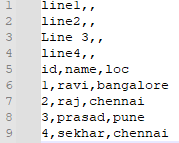




In [ ]:
sdf = sc.read.csv("exercise-3.csv", header = True)
sdf.show()

+------+------+---------+
| line1|   _c1|      _c2|
+------+------+---------+
| line2|  null|     null|
|Line 3|  null|     null|
| line4|  null|     null|
|    id|  name|      loc|
|     1|  ravi|bangalore|
|     2|   raj|  chennai|
|     3|prasad|     pune|
|     4|sekhar|  chennai|
+------+------+---------+



In [ ]:
rdd = sc.sparkContext.textFile("exercise-3.csv")
rdd.collect()
#rdd_final = rdd.zipWithIndex().filter( lambda pair: pair[1] > 3 ).map( lambda element: element[0].split(",") ).collect()

['line1,,',
 'line2,,',
 'Line 3,,',
 'line4,,',
 'id,name,loc',
 '1,ravi,bangalore',
 '2,raj,chennai',
 '3,prasad,pune',
 '4,sekhar,chennai']

`zipWithIndex()` returns a RDD of tuples where the first element of the tuple is the value and the second element is the index. The ordering is first based on the partition index and then the ordering of items within each partition. So the first item in the first partition gets index 0, and the last item in the last partition receives the largest index.

In [ ]:
rdd.zipWithIndex().collect()

[('line1,,', 0),
 ('line2,,', 1),
 ('Line 3,,', 2),
 ('line4,,', 3),
 ('id,name,loc', 4),
 ('1,ravi,bangalore', 5),
 ('2,raj,chennai', 6),
 ('3,prasad,pune', 7),
 ('4,sekhar,chennai', 8)]

Ignore the row 1 to 4 filtering with the index

In [ ]:
rdd.zipWithIndex().filter( lambda row: row[1] > 3 ).collect()

[('id,name,loc', 4),
 ('1,ravi,bangalore', 5),
 ('2,raj,chennai', 6),
 ('3,prasad,pune', 7),
 ('4,sekhar,chennai', 8)]

Using a map function to only obtain the first elemen of the tuple and ignoring the index value

In [ ]:
rdd_final = rdd.zipWithIndex().filter( lambda row: row[1] > 3 ).map( lambda row: row[0].split(",") )
rdd_final.collect()

[['id', 'name', 'loc'],
 ['1', 'ravi', 'bangalore'],
 ['2', 'raj', 'chennai'],
 ['3', 'prasad', 'pune'],
 ['4', 'sekhar', 'chennai']]

In [ ]:
#Separate the columns names with the rest of the data
columns = rdd_final.first()
data = rdd_final.filter(lambda record: record != columns)

sdf = sc.createDataFrame(data, columns)
sdf.printSchema()
sdf.show()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- loc: string (nullable = true)

+---+------+---------+
| id|  name|      loc|
+---+------+---------+
|  1|  ravi|bangalore|
|  2|   raj|  chennai|
|  3|prasad|     pune|
|  4|sekhar|  chennai|
+---+------+---------+



## 4. How to handle remove duplicate records based on updated date

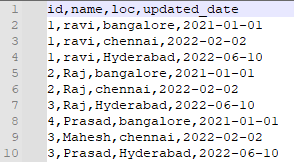


1.   `Disctinct(): `is used to return a new DataFrame containing the distinct rows in the original DataFrame1. It eliminates any rows that have the same values on all columns.
2.   `dropDuplicates() / drop_duplicates():` If you want to select distinct values on specific columns, you can use the dropDuplicates() function instead2. This function takes a list of columns as an argument and returns a new DataFrame with unique values on those columns

The difference between `distinct()` and dropDuplicates() in PySpark is that distinct() performs on all columns of the DataFrame and returns a new DataFrame with only unique rows, whereas dropDuplicates() performs on selected columns of the DataFrame and returns a new DataFrame with unique values on those columns

3.   window function with Row_number(): The row_number() function is a window function in PySpark that assigns a sequential number starting from 1 to each row in the result DataFrame12. This function is used with Window.partitionBy() which partitions the data into windows frames and orderBy() clause to sort the rows in each partition.
4.   groupBy with Count()

In [ ]:
sdf = sc.read.csv("exercise-4.csv", header = True, inferSchema = True)
sdf.printSchema()
sdf.show()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- loc: string (nullable = true)
 |-- updated_date: date (nullable = true)

+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  1|  ravi|bangalore|  2021-01-01|
|  1|  ravi|  chennai|  2022-02-02|
|  1|  ravi|Hyderabad|  2022-06-10|
|  2|   Raj|bangalore|  2021-01-01|
|  2|   Raj|  chennai|  2022-02-02|
|  3|   Raj|Hyderabad|  2022-06-10|
|  4|Prasad|bangalore|  2021-01-01|
|  3|Mahesh|  chennai|  2022-02-02|
|  3|Prasad|Hyderabad|  2022-06-10|
+---+------+---------+------------+



In [ ]:
#Remove the columns with the same id with dropDuplicates()
sdf.distinct().show()
#There aren't duplicate records

+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  2|   Raj|bangalore|  2021-01-01|
|  3|Prasad|Hyderabad|  2022-06-10|
|  1|  ravi|bangalore|  2021-01-01|
|  1|  ravi|Hyderabad|  2022-06-10|
|  4|Prasad|bangalore|  2021-01-01|
|  3|   Raj|Hyderabad|  2022-06-10|
|  2|   Raj|  chennai|  2022-02-02|
|  1|  ravi|  chennai|  2022-02-02|
|  3|Mahesh|  chennai|  2022-02-02|
+---+------+---------+------------+



In [ ]:
#Remove the columns with the same column "id" with dropDuplicates()
sdf.dropDuplicates(["id"]).show()

+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  1|  ravi|bangalore|  2021-01-01|
|  2|   Raj|bangalore|  2021-01-01|
|  3|   Raj|Hyderabad|  2022-06-10|
|  4|Prasad|bangalore|  2021-01-01|
+---+------+---------+------------+



remove duplicate records based on updated date considering the columns "updated_date" with the latest date


`orderBy()`: is used to sort a DataFrame based on one or more columns. It takes one or more columns as arguments and returns a new DataFrame sorted by the specified columns. By default, it sorts in ascending order, but you can also specify the sort order using the ascending parameter or the `desc()` method.

In [ ]:
from pyspark.sql.functions import col

print("Before drop")
sdf.orderBy(col("updated_date").desc()).show()

print("after drop only maintaining the latest date")
sdf.orderBy(col("updated_date").desc()).dropDuplicates(["id"]).show()

Before drop
+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  1|  ravi|Hyderabad|  2022-06-10|
|  3|   Raj|Hyderabad|  2022-06-10|
|  3|Prasad|Hyderabad|  2022-06-10|
|  1|  ravi|  chennai|  2022-02-02|
|  2|   Raj|  chennai|  2022-02-02|
|  3|Mahesh|  chennai|  2022-02-02|
|  1|  ravi|bangalore|  2021-01-01|
|  2|   Raj|bangalore|  2021-01-01|
|  4|Prasad|bangalore|  2021-01-01|
+---+------+---------+------------+

after drop only maintaining the latest date
+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  1|  ravi|Hyderabad|  2022-06-10|
|  2|   Raj|  chennai|  2022-02-02|
|  3|   Raj|Hyderabad|  2022-06-10|
|  4|Prasad|bangalore|  2021-01-01|
+---+------+---------+------------+



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

sdf = sdf.withColumn("rowid", row_number().over(Window.partitionBy("id").orderBy(col("updated_date").desc())))
sdf.show()
sdf.filter("rowid = 1").show()

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

The `Window.partitionBy()` function in PySpark is used to create a WindowSpec object with the partitioning defined. It takes one or more columns as arguments and returns a WindowSpec object that can be used with window functions to perform calculations over a group of rows that share the same values on the partitioning columns.

In [ ]:
windowSpec = Window.partitionBy("id").orderBy(col("updated_date").desc())

In [ ]:
sdf = sdf.withColumn("rowid", row_number().over(windowSpec))
sdf.show()

+---+------+---------+------------+-----+
| id|  name|      loc|updated_date|rowid|
+---+------+---------+------------+-----+
|  1|  ravi|Hyderabad|  2022-06-10|    1|
|  1|  ravi|  chennai|  2022-02-02|    2|
|  1|  ravi|bangalore|  2021-01-01|    3|
|  2|   Raj|  chennai|  2022-02-02|    1|
|  2|   Raj|bangalore|  2021-01-01|    2|
|  3|   Raj|Hyderabad|  2022-06-10|    1|
|  3|Prasad|Hyderabad|  2022-06-10|    2|
|  3|Mahesh|  chennai|  2022-02-02|    3|
|  4|Prasad|bangalore|  2021-01-01|    1|
+---+------+---------+------------+-----+



In [ ]:
sdf.filter(col("rowid") == 1).show()

+---+------+---------+------------+-----+
| id|  name|      loc|updated_date|rowid|
+---+------+---------+------------+-----+
|  1|  ravi|Hyderabad|  2022-06-10|    1|
|  2|   Raj|  chennai|  2022-02-02|    1|
|  3|   Raj|Hyderabad|  2022-06-10|    1|
|  4|Prasad|bangalore|  2021-01-01|    1|
+---+------+---------+------------+-----+



# 5.- How to get No of rows for each file

File 1:
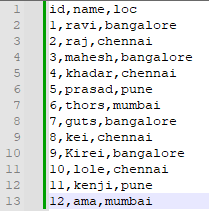

File 2:
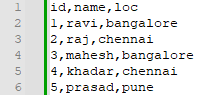

In [18]:
import pyspark
from pyspark.sql import SparkSession

In [19]:
sc = SparkSession.builder.getOrCreate()

read data from CSV files that match the pattern “*.csv” and returns a DataFrame

In [ ]:
sdfs = sc.read.csv("*.csv", header=True)
sdfs.show()

+---+-------+---------+
| id|   name|      loc|
+---+-------+---------+
|  1|   ravi|bangalore|
|  2|    raj|  chennai|
|  3| mahesh|bangalore|
|  4| khadar|  chennai|
|  5| prasad|     pune|
|  6|  thors|   mumbai|
|  7|   guts|bangalore|
|  8|    kei|  chennai|
|  9|  Kirei|bangalore|
| 10|   lole|  chennai|
| 11|  kenji|     pune|
| 12|    ama|   mumbai|
|  1|   ravi|bangalore|
|  2|    raj|  chennai|
|  3| mahesh|bangalore|
|  4| khadar|  chennai|
|  5| prasad|     pune|
|  6|sridhar|   mumbai|
+---+-------+---------+



`input_file_name` is a function that creates a string column for the file name of the current Spark task. It can be used to add the file name as a column in a DataFrame:

In [ ]:
from pyspark.sql.functions import input_file_name

sdfs = sdfs.withColumn("Filename", input_file_name())
sdfs.show(truncate=False)

+---+-------+---------+---------------------------------+
|id |name   |loc      |Filename                         |
+---+-------+---------+---------------------------------+
|1  |ravi   |bangalore|file:///content/customerdata2.csv|
|2  |raj    |chennai  |file:///content/customerdata2.csv|
|3  |mahesh |bangalore|file:///content/customerdata2.csv|
|4  |khadar |chennai  |file:///content/customerdata2.csv|
|5  |prasad |pune     |file:///content/customerdata2.csv|
|6  |thors  |mumbai   |file:///content/customerdata2.csv|
|7  |guts   |bangalore|file:///content/customerdata2.csv|
|8  |kei    |chennai  |file:///content/customerdata2.csv|
|9  |Kirei  |bangalore|file:///content/customerdata2.csv|
|10 |lole   |chennai  |file:///content/customerdata2.csv|
|11 |kenji  |pune     |file:///content/customerdata2.csv|
|12 |ama    |mumbai   |file:///content/customerdata2.csv|
|1  |ravi   |bangalore|file:///content/customerdata.csv |
|2  |raj    |chennai  |file:///content/customerdata.csv |
|3  |mahesh |b

In [ ]:
sdfs.groupBy("Filename").count().show(truncate=False)

+---------------------------------+-----+
|Filename                         |count|
+---------------------------------+-----+
|file:///content/customerdata2.csv|12   |
|file:///content/customerdata.csv |6    |
+---------------------------------+-----+



# 6.- how to get no of rows at each partition in DataFrame

Dataframe with multiple partitions.

How to take partition wise row count

dataskew issues

Data skew is a term that refers to the uneven distribution of data in a dataset or a database. Data skew can cause problems for data analysis and processing, as it can affect the accuracy, performance, and scalability of the system.

There are different types of data skew, such as:

* Skewness: A measure of the asymmetry of a probability distribution of a variable. A distribution can be right-skewed (positive skew) or left-skewed (negative skew) depending on which side has a longer tail.
* Partition skew: A situation where the data is not evenly distributed across the partitions or nodes of a distributed system. This can lead to load imbalance and resource wastage.
* Processing skew: A situation where some partitions or nodes take longer than others to process the data, usually due to data skew or complex operations.

In [ ]:
sdfs = sc.read.csv("*.csv", header=True)
sdfs.show()

+---+-------+---------+
| id|   name|      loc|
+---+-------+---------+
|  1|   ravi|bangalore|
|  2|    raj|  chennai|
|  3| mahesh|bangalore|
|  4| khadar|  chennai|
|  5| prasad|     pune|
|  6|  thors|   mumbai|
|  7|   guts|bangalore|
|  8|    kei|  chennai|
|  9|  Kirei|bangalore|
| 10|   lole|  chennai|
| 11|  kenji|     pune|
| 12|    ama|   mumbai|
|  1|   ravi|bangalore|
|  2|    raj|  chennai|
|  3| mahesh|bangalore|
|  4| khadar|  chennai|
|  5| prasad|     pune|
|  6|sridhar|   mumbai|
+---+-------+---------+



A partition is a logical chunk of data that is distributed across the nodes of a cluster for parallel processing. The getNumPartitions method is a method of the RDD class that returns an integer value representing the number of partitions in the RDD

In [ ]:
print(sdfs.rdd.getNumPartitions())

2


This line of code imports the `spark_partition_id` function from the `pyspark.sql.functions` module. The spark_partition_id function is a function that creates a column for the partition ID of the current Spark task1. It can be used to add the partition ID as a column in a DataFrame

In [ ]:
from pyspark.sql.functions import spark_partition_id

sdfs.select(spark_partition_id().alias("part_id")).groupBy("part_id").count().show()

+-------+-----+
|part_id|count|
+-------+-----+
|      0|   12|
|      1|    6|
+-------+-----+



# 7.- How to add a Sequence generated surrogate key as a column in dataframe

A sequence ID and a surrogate key are both ways of generating unique identifiers for each record in a table. A sequence ID is a number that increments by one for each new record, while a surrogate key is a system-generated value that may not have any meaning or relation to the data.

In Spark, you can use different methods to create sequence IDs or surrogate keys for your tables. One method is to use the monotonically_increasing_id function, which returns a unique and increasing value for each row1. Another method is to use the identity column feature in Delta Lake, which automatically generates a unique and auto-incrementing ID number for each new row of data2. Both methods require you to specify the column name and type when creating the table.

Using sequence IDs or surrogate keys has some **advantages and disadvantages**, depending on your data and requirements. Here are some of them:

**Advantages:**

They simplify the data integration process, as they are independent of the source data and can handle changes or inconsistencies in the source keys1.
They improve the performance and scalability of the system, as they are numeric and sequential, which makes them easy to index and join. They also reduce the size of the data warehouse tables, as they are shorter and more compact than the source keys12.
They enable historical analysis, as they can preserve the history of changes in the source data by creating new rows with new keys when the source data is updated or deleted1.


**Disadvantages:**

They add complexity and overhead to the data modeling and management process, as they are artificial and meaningless, which makes them harder to understand and document. They also require additional steps and tools to generate and maintain them12.
They may not be unique across different tables or systems, as they are generated locally and may have collisions or gaps. This can cause problems when merging or migrating data from different sources2.
They may not reflect the natural order or hierarchy of the data, as they are arbitrary and unrelated to the data values. This can make it difficult to perform some types of analysis or reporting that rely on the natural keys2.

In [20]:
sdf_emp = sc.read.option("nullValue", "null").csv("emp.csv", header=True, inferSchema=True).dropna(how="all").dropDuplicates(["EMPNO"])
sdf_emp.show()

+-----+------+---------+----+----------+----+----+------+------------+
|EMPNO| ENAME|      JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE|
+-----+------+---------+----+----------+----+----+------+------------+
| 1234|SEKHAR|   doctor|7777|      null| 667|  78|    80|  2022-01-03|
| 7369| SMITH|    CLERK|7902|17-12-1980| 800|null|    20|  2022-01-01|
| 7499| ALLEN| SALESMAN|7698|20-02-1981|1600| 300|    30|  2022-01-01|
| 7521|  WARD| SALESMAN|7698|22-02-1981|1250| 500|    30|  2022-01-01|
| 7566| JONES|  MANAGER|7839|04-02-1981|2975|null|    20|  2022-01-05|
| 7654|MARTIN| SALESMAN|7698|21-09-1981|1250|1400|    30|  2022-01-03|
| 7698|   SGR|  MANAGER|7839|05-01-1981|2850|null|    30|  2022-01-04|
| 7782|  RAVI|  MANAGER|7839|06-09-1981|2450|null|    10|  2022-01-02|
| 7788| SCOTT|  ANALYST|7566|19-04-1987|3000|null|    20|  2022-01-02|
| 7839|  KING|PRESIDENT|null|01-11-1981|5000|null|    10|  2022-01-02|
| 7844|TURNER| SALESMAN|7698|09-08-1981|1500|   0|    30|  2022-01-02|
| 7876

The `monotonically_increasing_id` function is a Spark SQL function that returns a unique and increasing value for each row in a DataFrame. The value is a 64-bit integer that is composed of the partition ID in the upper 31 bits and the record number within each partition in the lower 33 bits. The function is guaranteed to be monotonically increasing and unique, but not consecutive.

The function can be used to generate sequence IDs or surrogate keys for your tables, but it has some limitations and risks. For example, the function is non-deterministic, which means that its result depends on the partition IDs and may change if the DataFrame is repartitioned or shuffled. The function also assumes that the DataFrame has less than 1 billion partitions and each partition has less than 8 billion records, which may not hold for very large or skewed data. The function also does not reflect the natural order or hierarchy of the data, as it is unrelated to the data values.

In [21]:
from pyspark.sql.functions import monotonically_increasing_id

sdf_emp = sdf_emp.withColumn("id", monotonically_increasing_id())
sdf_emp.show()

+-----+------+---------+----+----------+----+----+------+------------+---+
|EMPNO| ENAME|      JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE| id|
+-----+------+---------+----+----------+----+----+------+------------+---+
| 1234|SEKHAR|   doctor|7777|      null| 667|  78|    80|  2022-01-03|  0|
| 7369| SMITH|    CLERK|7902|17-12-1980| 800|null|    20|  2022-01-01|  1|
| 7499| ALLEN| SALESMAN|7698|20-02-1981|1600| 300|    30|  2022-01-01|  2|
| 7521|  WARD| SALESMAN|7698|22-02-1981|1250| 500|    30|  2022-01-01|  3|
| 7566| JONES|  MANAGER|7839|04-02-1981|2975|null|    20|  2022-01-05|  4|
| 7654|MARTIN| SALESMAN|7698|21-09-1981|1250|1400|    30|  2022-01-03|  5|
| 7698|   SGR|  MANAGER|7839|05-01-1981|2850|null|    30|  2022-01-04|  6|
| 7782|  RAVI|  MANAGER|7839|06-09-1981|2450|null|    10|  2022-01-02|  7|
| 7788| SCOTT|  ANALYST|7566|19-04-1987|3000|null|    20|  2022-01-02|  8|
| 7839|  KING|PRESIDENT|null|01-11-1981|5000|null|    10|  2022-01-02|  9|
| 7844|TURNER| SALESMAN|7

The `row_number` function is a Spark SQL window function that returns a sequential number starting at 1 within a window partition. The window partition can be specified by using the Window class and its methods, such as partitionBy and `orderBy`. The function can be used to assign row numbers to each row in a DataFrame based on some criteria.

The `lit` function is a Spark SQL function that creates a column of literal value. The literal value can be any constant, such as a string, a number, or a boolean. The function can be used to add a new column to a DataFrame by assigning a literal value to each row.

In [22]:
from pyspark.sql.functions import row_number, lit
from pyspark.sql.window import Window

sdf_emp = sdf_emp.withColumn("row_number", row_number().over(Window.partitionBy(lit("")).orderBy(lit(""))))
sdf_emp.show()

+-----+------+---------+----+----------+----+----+------+------------+---+----------+
|EMPNO| ENAME|      JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE| id|row_number|
+-----+------+---------+----+----------+----+----+------+------------+---+----------+
| 1234|SEKHAR|   doctor|7777|      null| 667|  78|    80|  2022-01-03|  0|         1|
| 7369| SMITH|    CLERK|7902|17-12-1980| 800|null|    20|  2022-01-01|  1|         2|
| 7499| ALLEN| SALESMAN|7698|20-02-1981|1600| 300|    30|  2022-01-01|  2|         3|
| 7521|  WARD| SALESMAN|7698|22-02-1981|1250| 500|    30|  2022-01-01|  3|         4|
| 7566| JONES|  MANAGER|7839|04-02-1981|2975|null|    20|  2022-01-05|  4|         5|
| 7654|MARTIN| SALESMAN|7698|21-09-1981|1250|1400|    30|  2022-01-03|  5|         6|
| 7698|   SGR|  MANAGER|7839|05-01-1981|2850|null|    30|  2022-01-04|  6|         7|
| 7782|  RAVI|  MANAGER|7839|06-09-1981|2450|null|    10|  2022-01-02|  7|         8|
| 7788| SCOTT|  ANALYST|7566|19-04-1987|3000|null|    

The `crc32` function in Spark is a built-in function that calculates the cyclic redundancy check value (CRC32) of a binary column and returns the value as a bigint. A CRC32 is a type of hash function that uses a polynomial division algorithm to convert data of any length into a fixed-length binary sequence. It is used to detect changes or errors in data transmission or storage.

The crc32 function can be used in Spark SQL or in the DataFrame API

In [23]:
#It can generate duplicates 100k or 200k records
from pyspark.sql.functions import crc32, col

sdf_emp = sdf_emp.withColumn("crc32_key", crc32(col("EMPNO").cast("string")))
sdf_emp.show()

+-----+------+---------+----+----------+----+----+------+------------+---+----------+----------+
|EMPNO| ENAME|      JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE| id|row_number| crc32_key|
+-----+------+---------+----+----------+----+----+------+------------+---+----------+----------+
| 1234|SEKHAR|   doctor|7777|      null| 667|  78|    80|  2022-01-03|  0|         1|2615402659|
| 7369| SMITH|    CLERK|7902|17-12-1980| 800|null|    20|  2022-01-01|  1|         2|3163315632|
| 7499| ALLEN| SALESMAN|7698|20-02-1981|1600| 300|    30|  2022-01-01|  2|         3|1046173690|
| 7521|  WARD| SALESMAN|7698|22-02-1981|1250| 500|    30|  2022-01-01|  3|         4|3535170612|
| 7566| JONES|  MANAGER|7839|04-02-1981|2975|null|    20|  2022-01-05|  4|         5| 683555987|
| 7654|MARTIN| SALESMAN|7698|21-09-1981|1250|1400|    30|  2022-01-03|  5|         6|4024152101|
| 7698|   SGR|  MANAGER|7839|05-01-1981|2850|null|    30|  2022-01-04|  6|         7|1255715586|
| 7782|  RAVI|  MANAGER|7839|0

The md5 function in Spark is a built-in function that calculates the MD5 digest and returns the value as a 32 character hex string. MD5 is a commonly used message digest algorithm that uses a polynomial division algorithm to convert data of any length into a 128-bit binary sequence. It is used to detect changes or errors in data transmission or storage.

In [24]:
from pyspark.sql.functions import md5

sdf_emp = sdf_emp.withColumn("md5_key", md5(col("EMPNO").cast("string")))
sdf_emp.show()

+-----+------+---------+----+----------+----+----+------+------------+---+----------+----------+--------------------+
|EMPNO| ENAME|      JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE| id|row_number| crc32_key|             md5_key|
+-----+------+---------+----+----------+----+----+------+------------+---+----------+----------+--------------------+
| 1234|SEKHAR|   doctor|7777|      null| 667|  78|    80|  2022-01-03|  0|         1|2615402659|81dc9bdb52d04dc20...|
| 7369| SMITH|    CLERK|7902|17-12-1980| 800|null|    20|  2022-01-01|  1|         2|3163315632|0d7f9017fbda69190...|
| 7499| ALLEN| SALESMAN|7698|20-02-1981|1600| 300|    30|  2022-01-01|  2|         3|1046173690|7a2b33c672ce223b2...|
| 7521|  WARD| SALESMAN|7698|22-02-1981|1250| 500|    30|  2022-01-01|  3|         4|3535170612|e1e1f667ce4596e56...|
| 7566| JONES|  MANAGER|7839|04-02-1981|2975|null|    20|  2022-01-05|  4|         5| 683555987|b937384a573b94c4d...|
| 7654|MARTIN| SALESMAN|7698|21-09-1981|1250|1400|    30

The sha2 function in Spark is a built-in function that returns the hex string result of SHA-2 family of hash functions (SHA-224, SHA-256, SHA-384, and SHA-512). SHA-2 is a set of cryptographic hash functions that use a polynomial division algorithm to convert data of any length into a fixed-length binary sequence. It is used to verify the integrity and authenticity of data transmission or storage.

The sha2 function can be used in Spark SQL or in the DataFrame API. The function takes two arguments: the input expression and the desired bit length of the result, which must have a value of 224, 256, 384, 512, or 0 (which is equivalent to 256).

In [25]:
from pyspark.sql.functions import sha2

sdf_emp = sdf_emp.withColumn("sha2_key", sha2(col("EMPNO").cast("string"), 256))
sdf_emp.show()

+-----+------+---------+----+----------+----+----+------+------------+---+----------+----------+--------------------+--------------------+
|EMPNO| ENAME|      JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE| id|row_number| crc32_key|             md5_key|            sha2_key|
+-----+------+---------+----+----------+----+----+------+------------+---+----------+----------+--------------------+--------------------+
| 1234|SEKHAR|   doctor|7777|      null| 667|  78|    80|  2022-01-03|  0|         1|2615402659|81dc9bdb52d04dc20...|03ac674216f3e15c7...|
| 7369| SMITH|    CLERK|7902|17-12-1980| 800|null|    20|  2022-01-01|  1|         2|3163315632|0d7f9017fbda69190...|c59f438f16c5a409e...|
| 7499| ALLEN| SALESMAN|7698|20-02-1981|1600| 300|    30|  2022-01-01|  2|         3|1046173690|7a2b33c672ce223b2...|4427dc2e32a1d099d...|
| 7521|  WARD| SALESMAN|7698|22-02-1981|1250| 500|    30|  2022-01-01|  3|         4|3535170612|e1e1f667ce4596e56...|74ed8ca63e8b4fb8b...|
| 7566| JONES|  MANAGER|783

# 8.- How to get Individual column wise null records count / How to get No of null rows at each column from a dataframe



In [26]:
sdf_emp = sc.read.option("nullValue", "null").csv("emp.csv", header=True, inferSchema=True)
sdf_emp.show()

+-----+------+---------+----+----------+----+----+------+------------+
|EMPNO| ENAME|      JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE|
+-----+------+---------+----+----------+----+----+------+------------+
| 7369| SMITH|    CLERK|7902|17-12-1980| 800|null|    20|  2022-01-01|
| 7499| ALLEN| SALESMAN|7698|20-02-1981|1600| 300|    30|  2022-01-01|
| 7521|  WARD| SALESMAN|7698|22-02-1981|1250| 500|    30|  2022-01-01|
| 7566| JONES|  MANAGER|7839|04-02-1981|2975|null|    20|  2022-01-05|
| 7654|MARTIN| SALESMAN|7698|21-09-1981|1250|1400|    30|  2022-01-03|
| 7698|   SGR|  MANAGER|7839|05-01-1981|2850|null|    30|  2022-01-04|
| 7782|  RAVI|  MANAGER|7839|06-09-1981|2450|null|    10|  2022-01-02|
| 7788| SCOTT|  ANALYST|7566|19-04-1987|3000|null|    20|  2022-01-02|
| 7839|  KING|PRESIDENT|null|01-11-1981|5000|null|    10|  2022-01-02|
| 7844|TURNER| SALESMAN|7698|09-08-1981|1500|   0|    30|  2022-01-02|
| 7876| ADAMS|    CLERK|7788|23-05-1987|1100|null|    20|  2022-01-03|
| 7900

In [31]:
sdf_emp.filter("mgr is null").count()

5

The `count` function in Spark is an aggregate function that returns the number of items in a group. The count function can take a column name or an expression as an argument and returns a bigint value. The count function can be used in Spark SQL or in the DataFrame API.

The `when` function in Spark is a conditional function that evaluates a list of conditions and returns one of multiple possible result expressions. The when function can take two arguments: a condition and a value. The when function can be chained with the otherwise function to specify the default value when none of the conditions are met. The when function can be used in Spark SQL or in the DataFrame API.  If the condition is not met, the function returns None, unless `pyspark.sql.Column.otherwise()` is invoked to specify a default value.

In [33]:
from pyspark.sql.functions import count, col, when

sdf_emp.select([count(when(col(column).isNull(), column)).alias(column) for column in sdf_emp.columns]).show()

+-----+-----+---+---+--------+---+----+------+------------+
|EMPNO|ENAME|JOB|MGR|HIREDATE|SAL|COMM|DEPTNO|UPDATED_DATE|
+-----+-----+---+---+--------+---+----+------+------------+
|    3|    3|  3|  5|       5|  3|  23|     3|           3|
+-----+-----+---+---+--------+---+----+------+------------+



To use the when function with complex conditions, you can use the following tips:

Use parentheses to enclose each condition and expression to avoid ambiguity and enforce the desired operator precedence.
Use & (bitwise AND) and | (bitwise OR) operators to combine multiple conditions, as they have higher precedence than comparison operators12. Do not use and and or operators, as they are not supported for column expressions.
Use ~ (bitwise NOT) operator to negate a condition, as it has higher precedence than comparison operators2.
Use isNull(), isNotNull(), or isin() methods to check for null values, missing values, or multiple values in a column3.
Use between() method to check if a column value is within a range of values.